In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pdb

class Izh:
    def __init__(self, neuron_type):
        self.neuron_type = neuron_type
        self.spike_times = np.array([])

        if self.neuron_type == "RS":
            self.a = 0.03
            self.b = -2.
            self.vreset=-50.  #also called 'c'
            self.d=100.0
            self.k=0.7
            self.vr=-60.
            self.vt=-40.
            self.vpeak=35.
            self.E=0.
            self.V0=-60.
            self.u0=0.
            self.C=100.


        elif self.neuron_type == "MSN":
            self.a = 0.01
            self.b = -20.
            self.vreset=-55.
            self.d=150.
            self.k=1.
            self.vr=-80.
            self.vt=-25.
            self.vpeak=40.
            self.E=70.
            self.V0=-60.
            self.u0=0.
            self.C=50.


        self.reset_state_variables () # For u, v. temp, post arrays: They get their own method in case we want to reset
                                        #  them directly withough recreating a new instance,
                                        #e.g., if we want to run more   than 1 trial in the experiment
        self.noise_mean = 0
        self.noise_std = 10
        self.epsilon= np.random.normal(self.noise_mean, self.noise_std, size=tMax)
        #self.sigma = 25 #adjusts the epsilon noise magnitudeself.sigma = 15 #adjusts the epsilon noise magnitude
        self.sigma = 0 #adjusts the epsilon noise magnitude, e.g., ALMprep.sigma=15

    def reset_state_variables (self):  #see comment in self.reset_state.. above .
        self.v = np.full(tMax, self.V0)
        self.u = np.full(tMax, self.u0)
        self.tempa= np.zeros(tMax)   #tempa holds the alpha values generated by the latest spike
        self.post = np.zeros(tMax)  #post keeps running total of the tempa values for a given neuron

    def stimulate(self, Stim):   #SOMAT neuron passes Sample array as Stim, t=1000 to 2000.
                                 #PPN neuron passes Go_cue as Stim, t =3000-3200
        for i in range(tMax - 1):
          
          self.v[i + 1] = self.v[i] +  (self.k * (self.v[i] - self.vr) * (self.v[i] - self.vt)
                - self.u[i] + self.E + Stim[i]  + self.sigma * self.epsilon[i]) / self.C
          self.u[i + 1] = self.u[i] + self.a * (self.b * (self.v[i] - self.vr) - self.u[i])
          if self.v[i + 1] >= self.vpeak:
              self.v[i] = self.vpeak
              self.v[i + 1] = self.vreset
              self.u[i + 1] = self.u[i + 1] + self.d
              if i < tMax - alphaMax+1:
                  self.tempa = np.concatenate((np.zeros(i), alpha_values, np.zeros(tMax - alphaMax - i)))
                  self.post += self.tempa
              self.spike_times = np.append(self.spike_times, i)
              

    def CTC_BG_Circuit (self, Somat_ALMprep_wt,  Somat_MSNinstr_wt, MSNinstr_SNRinstr_wt, SNRinstr_VMprep_wt, VMprep_ALMprep_wt, ALMprep_VMprep_wt, ALMprep_MSNprep_wt,
                MSNprep_SNRprep_wt, SNRprep_VMresp_wt, PPN_THAL_GO_wt, THAL_GO_ALM_INTER_wt, ALM_INTER_ALMprep_wt, THAL_GO_ALMresp_wt,
                ALMresp_MSNresp_wt, MSNresp_SNR3_wt, SNR3_VMresp_wt, VMresp_ALMresp_wt, ALMresp_VMresp_wt):

        for i in range(tMax - 1):
            n=MSNinstr
            v0=float(n.v[i])
            u0=float(n.u[i])

            #Somat.post is calculated in Somat.stimulate function
            MSNinstr.v[i+1] = MSNinstr.v[i]+(MSNinstr.k * (MSNinstr.v[i] - MSNinstr.vr) * (MSNinstr.v[i] - MSNinstr.vt)
                - MSNinstr.u[i] + MSNinstr.E +  Somat.post[i]*Somat_MSNinstr_wt
                + MSNinstr.sigma * MSNinstr.epsilon[i]) / MSNinstr.C
            MSNinstr.u[i + 1] = MSNinstr.u[i] + MSNinstr.a * (MSNinstr.b * (MSNinstr.v[i] - MSNinstr.vr) - MSNinstr.u[i])
  
    
            input = Somat.post[i]*Somat_MSNinstr_wt
            v1 = float(n.v[i+1])
            u1 = float(n.u[i+1])

            if 10>i:
                print(f'time | (V0,u0) | input | (V1,u1)')
                print(f'{i} | {v0:.4f}, {u0:.4f} | {input:.4f} | {v1:.4f}, {u1:.4f}')
    
            #if 1001 <= i + 1 <= 2000:
                #MSNinstr.v[i + 1] = MSNinstr.vr
            if MSNinstr.v[i + 1] >= MSNinstr.vpeak:
                MSNinstr.spike_and_output(i)
                v2pre=float(n.v[i])
                v2post=float(n.v[i+1])
                print('spiked')
                print(f'values of v[t] and v[t+1] after spiking: {v0}, {v1}')




            SNRinstr.v[i+1] = SNRinstr.v[i]+(SNRinstr.k * (SNRinstr.v[i] - SNRinstr.vr) * (SNRinstr.v[i] - SNRinstr.vt)
                - SNRinstr.u[i] + SNRinstr.E - MSNinstr.post[i]*MSNinstr_SNRinstr_wt
                + SNRinstr.sigma * SNRinstr.epsilon[i]) / SNRinstr.C
            SNRinstr.u[i + 1] = SNRinstr.u[i] + SNRinstr.a * (SNRinstr.b * (SNRinstr.v[i] - SNRinstr.vr) - SNRinstr.u[i])
            if SNRinstr.v[i + 1] >= SNRinstr.vpeak:
                 SNRinstr.spike_and_output(i)

            VMprep.v[i+1] = VMprep.v[i]+(VMprep.k * (VMprep.v[i] - VMprep.vr) * (VMprep.v[i] - VMprep.vt)
                - VMprep.u[i] + VMprep.E +  ALMprep.post[i]*ALMprep_VMprep_wt - (SNRinstr.post[i] * SNRinstr_VMprep_wt)
                + VMprep.sigma * VMprep.epsilon[i]) / VMprep.C
            VMprep.u[i + 1] = VMprep.u[i] + VMprep.a * (VMprep.b * (VMprep.v[i] - VMprep.vr) - VMprep.u[i])
            #PHOTOINHIBI [Delay-period silencing] BETWEEEN 2000-3000
            #if 2001 <= i + 1 <= 3000:
            #    VMprep.v[i + 1] = VMprep.vr

            if VMprep.v[i + 1] >= VMprep.vpeak:
                VMprep.spike_and_output(i)

            ALMprep.v[i + 1] = ALMprep.v[i] + (ALMprep.k * (ALMprep.v[i] - ALMprep.vr) * (ALMprep.v[i] - ALMprep.vt)
                - ALMprep.u[i] + ALMprep.E  + Somat.post[i]*Somat_ALMprep_wt+ VMprep.post[i]*VMprep_ALMprep_wt - ALM_INTER.post[i]*ALM_INTER_ALMprep_wt
                + ALMprep.sigma * ALMprep.epsilon[i]) / ALMprep.C
            ALMprep.u[i + 1] = ALMprep.u[i] + ALMprep.a * (ALMprep.b * (ALMprep.v[i] - ALMprep.vr) - ALMprep.u[i])
            #PHOTOINHIBI [Delay-period silencing] BETWEEEN 2000-3000
            #if 2001 <= i + 1 <= 3000:
            #    ALMprep.v[i + 1] = ALMprep.vr
            #
            #PHOTOINHIB [SILENCING]] during RESPONSE PERIOD
            #if 3001 <= i + 1 <= 3200:
            #   ALMprep.v[i + 1] = ALMprep.vr

            if ALMprep.v[i + 1] >= ALMprep.vpeak:
                ALMprep.spike_and_output (i)

            MSNprep.v[i+1] = MSNprep.v[i]+(MSNprep.k * (MSNprep.v[i] - MSNprep.vr) * (MSNprep.v[i] - MSNprep.vt)
                - MSNprep.u[i] + MSNprep.E +  ALMprep.post[i]*ALMprep_MSNprep_wt
                + MSNprep.sigma * MSNprep.epsilon[i]) / MSNprep.C
            MSNprep.u[i + 1] = MSNprep.u[i] + MSNprep.a * (MSNprep.b * (MSNprep.v[i] - MSNprep.vr) - MSNprep.u[i])
            if MSNprep.v[i + 1] >= MSNprep.vpeak:
                MSNprep.spike_and_output(i)

            SNRprep.v[i+1] = SNRprep.v[i]+(SNRprep.k * (SNRprep.v[i] - SNRprep.vr) * (SNRprep.v[i] - SNRprep.vt)
                - SNRprep.u[i] + SNRprep.E -MSNprep.post[i]*MSNprep_SNRprep_wt
                + SNRprep.sigma * SNRprep.epsilon[i]) / SNRprep.C
            SNRprep.u[i + 1] = SNRprep.u[i] + SNRprep.a * (SNRprep.b * (SNRprep.v[i] - SNRprep.vr) - SNRprep.u[i])
            if SNRprep.v[i + 1] >= SNRprep.vpeak:
                 SNRprep.spike_and_output(i)

            THAL_GO.v[i+1] = THAL_GO.v[i]+(THAL_GO.k * (THAL_GO.v[i] - THAL_GO.vr) * (THAL_GO.v[i] - THAL_GO.vt)
                - THAL_GO.u[i] + THAL_GO.E + PPN.post[i]*PPN_THAL_GO_wt
                + THAL_GO.sigma * THAL_GO.epsilon[i]) / THAL_GO.C
            THAL_GO.u[i + 1] = THAL_GO.u[i] + THAL_GO.a * (THAL_GO.b * (THAL_GO.v[i] - THAL_GO.vr) - THAL_GO.u[i])
            if THAL_GO.v[i + 1] >= THAL_GO.vpeak:
                 THAL_GO.spike_and_output(i)

            ALM_INTER.v[i+1] = ALM_INTER.v[i]+(ALM_INTER.k * (ALM_INTER.v[i] - ALM_INTER.vr) * (ALM_INTER.v[i] - ALM_INTER.vt)
                - ALM_INTER.u[i] + ALM_INTER.E + THAL_GO.post[i]*THAL_GO_ALM_INTER_wt
                + ALM_INTER.sigma * ALM_INTER.epsilon[i]) / ALM_INTER.C
            ALM_INTER.u[i + 1] = ALM_INTER.u[i] + ALM_INTER.a * (ALM_INTER.b * (ALM_INTER.v[i] - ALM_INTER.vr) - ALM_INTER.u[i])
            if ALM_INTER.v[i + 1] >= ALM_INTER.vpeak:
                 ALM_INTER.spike_and_output(i)


            VMresp.v[i+1] = VMresp.v[i]+(VMresp.k * (VMresp.v[i] - VMresp.vr) * (VMresp.v[i] - VMresp.vt)
                - VMresp.u[i] + VMresp.E +  (ALMresp.post[i]*ALMresp_VMresp_wt) - (SNRprep.post[i] * SNRprep_VMresp_wt) - (SNR3.post[i] * SNR3_VMresp_wt)
                + VMresp.sigma * VMresp.epsilon[i]) / VMresp.C
            VMresp.u[i + 1] = VMresp.u[i] + VMresp.a * (VMresp.b * (VMresp.v[i] - VMresp.vr) - VMresp.u[i])
            if VMresp.v[i + 1] >= VMresp.vpeak:
                VMresp.spike_and_output(i)

            ALMresp.v[i + 1] = ALMresp.v[i] + (ALMresp.k * (ALMresp.v[i] - ALMresp.vr) * (ALMresp.v[i] - ALMresp.vt)
                - ALMresp.u[i] + ALMresp.E  + THAL_GO.post[i]*THAL_GO_ALMresp_wt   + VMresp.post[i]*VMresp_ALMresp_wt + ALMresp.sigma * ALMresp.epsilon[i]) / ALMresp.C
            ALMresp.u[i + 1] = ALMresp.u[i] + ALMresp.a * (ALMresp.b * (ALMresp.v[i] - ALMresp.vr) - ALMresp.u[i])
            #PHOTOINHIB [silencing] during RESPONSE PERIOD
            #if 3001 <= i + 1 <= 3200:
            #   ALMresp.v[i + 1] = ALMresp.vr

            if ALMresp.v[i + 1] >= ALMresp.vpeak:
                ALMresp.spike_and_output (i)

            MSNresp.v[i+1] = MSNresp.v[i]+(MSNresp.k * (MSNresp.v[i] - MSNresp.vr) * (MSNresp.v[i] - MSNresp.vt)
                - MSNresp.u[i] + MSNresp.E  + ALMresp.post[i]*ALMresp_MSNresp_wt
                + MSNresp.sigma * MSNresp.epsilon[i]) / MSNresp.C
            MSNresp.u[i + 1] = MSNresp.u[i] + MSNresp.a * (MSNresp.b * (MSNresp.v[i] - MSNresp.vr) - MSNresp.u[i])
            if MSNresp.v[i + 1] >= MSNresp.vpeak:
                MSNresp.spike_and_output(i)

            SNR3.v[i+1] = SNR3.v[i]+(SNR3.k * (SNR3.v[i] - SNR3.vr) * (SNR3.v[i] - SNR3.vt)
                - SNR3.u[i] + SNR3.E - (MSNresp.post[i]*MSNresp_SNR3_wt)
                + SNRprep.sigma * SNRprep.epsilon[i]) / SNRprep.C
            SNR3.u[i + 1] = SNR3.u[i] + SNR3.a * (SNR3.b * (SNR3.v[i] - SNR3.vr) - SNR3.u[i])
            if SNR3.v[i + 1] >= SNR3.vpeak:
                 SNR3.spike_and_output(i)



    def spike_and_output (self, i):
        self.v[i] = self.vpeak
        self.v[i + 1] = self.vreset
        self.u[i + 1] += self.d
        if i < tMax - 251:
            self.tempa = np.concatenate((np.zeros(i), alpha_values, np.zeros(tMax - alphaMax - i)))
            self.post += self.tempa
        self.spike_times = np.append(self.spike_times, i)


    def plot_membrane_potential(self, plot_neuron, plot_start=0, plot_end=4750, **kwargs):
        #**kwargs ('key word arguments') lets you to pass any  number of keyword arguments to a function.
        # -- without defining them in the function's parameter list
        plt.figure(figsize=(4, 4))  # figure size-- Horiz,Vertical
        ax1=plt.subplot(3, 1, 1)
        plt.plot(np.arange(1, tMax+1), self.v)
        plt.axis([plot_start, plot_end, -100, 100])
        # Extract the additional parameter name and value
        if kwargs:
            param_name, param_value = list(kwargs.items())[0]
            #kwargs is a dictionary of all keyword arguments passed to the function
            #if there are any keyword arguments,  kwargs.items() returns a view object that displays a list of the dictionary's key-value tuple pairs.
            # For example, if kwargs is {'MSNinstr_SNRinstr': 50}, then kwargs.items() will return dict_items([('MSNinstr_SNRinstr', 50)]).
            title = f"{plot_neuron}: {param_value}"
            #title = f"{plot_neuron}: {param_name}={param_value}"
        else:
            title = f"{plot_neuron}"
        plt.title(title)
        #plt.xlabel("Time")
        plt.ylabel("Potential (mV)")
    #    ax1.axhline(y=80, xmin=Sample_start/(tMax-alphaMax), xmax=Sample_end/(tMax-alphaMax), color='r', ls='--',label='Sample')
        plt.hlines(y = 80, xmin = 1000, xmax = 2000, color = 'r', linestyle = '--', linewidth = 2)
        plt.show()

    def plot_alpha(self, plot_neuron, plot_start=0, plot_end=4750):
        plt.figure(figsize=(2, 2))  # figure size-- Horiz,Vertical
        plt.subplot(3, 1, 2)
        plt.plot(np.arange(1, tMax+1), self.post)
        plt.axis([plot_start, plot_end, -5, 7])
        plt.title(f"{plot_neuron}: Alpha Values")
        #plt.xlabel("Time")
        plt.ylabel("Alpha output")
        plt.show()

#------------------ANALYSES
# SPIKES PER BIN
    def spikes_per_bin (self, neuron_name='', bin_size=1000):
        bin_edges = np.arange(0, tMax + 1, bin_size)
        spike_counts, _ = np.histogram(self.spike_times, bin_edges)
        formatted_counts = ';'.join(map(str, spike_counts)) + ';'  # Convert counts to semicolon-separated format
        print()
        print(f"{neuron_name}, bins = {bin_size};")
        print(f"{formatted_counts};")
        #print(f"rates = {spike_counts*1000/bin_size}")


print('run define 2')

tMax=5000
W_Sample = 150
W_go = 850
Somat_MSNinstr = 220
Somat_ALMprep = 40

Somat=Izh ('RS')
Somat.sigma=0 #--------------------------sigma----------
MSNinstr=Izh('MSN')
MSNprep=Izh('MSN')
MSNresp=Izh ('MSN')
SNRinstr = Izh ('RS')
SNRinstr.E=120  #return to 120
SNRinstr.sigma=0 #------------------sigma
SNRprep=Izh('RS')
SNRprep.E=120 #120
#108-132 good
SNRprep.sigma=0 #------------------sigma


SNR3=Izh('RS')
SNR3.E=120  
ALMprep=Izh('RS')
# ALMprep.sigma=15
ALMprep.E=0  #see values below,
ALMresp= Izh('RS')

VMprep=Izh('RS')
VMprep.sigma=0 #------------------sigma

VMresp=Izh('RS')
VMresp.sigma=0 #------------------sigma
PPN=Izh ('RS')  #baseline firing = 20 Hz; evoked response= 80-100Hz (lat = 10 ms)
PPN.E=100  #originally 85 (18Hz) (See JH PPN obsid)
THAL_GO=Izh('RS')  #Respond to go signal in about 17ms; BASELINE= 17Hz; Evoked = 40Hz
ALM_INTER=Izh('RS') #EXC Response to GO signal in about 25 ms;


run define 2


In [13]:
MSNinstr_SNRinstr=90 #90
SNRinstr_VMprep =10 #10
VMprep_ALMprep=70  # 70;
ALMprep_VMprep=80 
ALMprep_MSNprep=320 #320
MSNprep_SNRprep=50
SNRprep_VMresp=100 #NEW 100
PPN_THAL_GO=60; #60; 45 weight evokes THAL_GO of 40 Hz response on top of about 15 Hz background rate)
THAL_GO_ALM_INTER = 55   #55;   originally 40, which evokes 40 Hz w background of 0; #50 evokes 40 hz w background of 10;
ALM_INTER_ALMprep = 50 #50 originally 40
THAL_GO_ALMresp=30 #30
ALMresp_MSNresp=320 #320
MSNresp_SNR3=90  #HERE 90
SNR3_VMresp=50   # 50
VMresp_ALMresp=85 #85
ALMresp_VMresp=90  #originally 90;

alphaMax=250
td = np.arange(1, alphaMax+1)
L=30
alpha_values = td/L * np.exp((L-td)/L)

Sample = np.zeros(tMax)
Go_cue= np.zeros(tMax)
Sample_start = 1000
Sample_end = 2000

Sample [Sample_start:Sample_end] = W_Sample
Go_start=3000
Go_end=3100
Go_cue [Go_start:Go_end] = W_go

Somat.stimulate(Sample)  #Stim neuron and record membrane potential and alpha values
                        # v and u arrays fill for tMax
PPN.stimulate(Go_cue)

"""RUN CIRCUIT"""

ALMprep.CTC_BG_Circuit (
    Somat_ALMprep_wt=Somat_ALMprep,
    Somat_MSNinstr_wt= Somat_MSNinstr,  #threshold weights is about 50
    MSNinstr_SNRinstr_wt= MSNinstr_SNRinstr,
    SNRinstr_VMprep_wt=  SNRinstr_VMprep,
    VMprep_ALMprep_wt= VMprep_ALMprep,
    ALMprep_VMprep_wt= ALMprep_VMprep,
    ALMprep_MSNprep_wt=ALMprep_MSNprep,
    MSNprep_SNRprep_wt= MSNprep_SNRprep,
    SNRprep_VMresp_wt=SNRprep_VMresp,
    PPN_THAL_GO_wt=PPN_THAL_GO,
    THAL_GO_ALM_INTER_wt=THAL_GO_ALM_INTER,
    ALM_INTER_ALMprep_wt =ALM_INTER_ALMprep,
    THAL_GO_ALMresp_wt=THAL_GO_ALMresp,
    ALMresp_MSNresp_wt=ALMresp_MSNresp,
    MSNresp_SNR3_wt=MSNresp_SNR3,
    SNR3_VMresp_wt=SNR3_VMresp,
    VMresp_ALMresp_wt=VMresp_ALMresp,
    ALMresp_VMresp_wt=ALMresp_VMresp)


time | (V0,u0) | input | (V1,u1)
0 | -60.0000, 0.0000 | 0.0000 | -72.6000, -4.0000
time | (V0,u0) | input | (V1,u1)
1 | -72.6000, -4.0000 | 0.0000 | -78.1648, -5.4400
time | (V0,u0) | input | (V1,u1)
2 | -78.1648, -5.4400 | 0.0000 | -78.6074, -5.7526
time | (V0,u0) | input | (V1,u1)
3 | -78.6074, -5.7526 | 0.0000 | -78.5854, -5.9736
time | (V0,u0) | input | (V1,u1)
4 | -78.5854, -5.9736 | 0.0000 | -78.5820, -6.1968
time | (V0,u0) | input | (V1,u1)
5 | -78.5820, -6.1968 | 0.0000 | -78.5777, -6.4185
time | (V0,u0) | input | (V1,u1)
6 | -78.5777, -6.4185 | 0.0000 | -78.5734, -6.6387
time | (V0,u0) | input | (V1,u1)
7 | -78.5734, -6.6387 | 0.0000 | -78.5692, -6.8577
time | (V0,u0) | input | (V1,u1)
8 | -78.5692, -6.8577 | 0.0000 | -78.5650, -7.0753
time | (V0,u0) | input | (V1,u1)
9 | -78.5650, -7.0753 | 0.0000 | -78.5608, -7.2915
spiked
values of v[t] and v[t+1] after spiking: 33.458875927691864, 183.93636068468976
spiked
values of v[t] and v[t+1] after spiking: -4.871595370095363, 42.893

In [6]:
alphaMax=250
td = np.arange(1, alphaMax+1)
L=30
alpha_values = td/L * np.exp((L-td)/L)
for i in range(alphaMax):
    print(f'{alpha_values[i]*Somat_MSNinstr:.4f}')


19.2806
37.2969
54.1113
69.7831
84.3691
97.9238
110.4991
122.1445
132.9077
142.8338
151.9663
160.3465
168.0138
175.0061
181.3593
187.1079
192.2847
196.9209
201.0464
204.6898
207.8783
210.6376
212.9927
214.9669
216.5827
217.8616
218.8238
219.4888
219.8750
220.0000
219.8805
219.5323
218.9707
218.2099
217.2636
216.1449
214.8660
213.4387
211.8740
210.1825
208.3742
206.4586
204.4446
202.3407
200.1551
197.8953
195.5686
193.1817
190.7411
188.2529
185.7229
183.1564
180.5586
177.9343
175.2879
172.6239
169.9461
167.2584
164.5642
161.8670
159.1697
156.4753
153.7864
151.1057
148.4355
145.7780
143.1352
140.5090
137.9011
135.3132
132.7468
130.2032
127.6837
125.1895
122.7216
120.2809
117.8684
115.4848
113.1308
110.8070
108.5140
106.2523
104.0222
101.8241
99.6584
97.5252
95.4248
93.3573
91.3227
89.3213
87.3529
85.4176
83.5153
81.6459
79.8093
78.0054
76.2340
74.4949
72.7879
71.1128
69.4692
67.8570
66.2759
64.7254
63.2054
61.7156
60.2554
58.8247
57.4230
56.0500
54.7053
53.3885
52.0993
50.8372
49.6019
48

Sample: 150 SNR background: 120 ; PPN background= 100
ALM_prep is an RS neuron
Weights:
Somat_ALM:1000; Somat_MSNinstr:1000;MSNinstr_SNRinstr 90; SNRinstr_VMprep:10; VMprep_ALMprep:70;  ALMprep_VMprep:80;   ALMprep_MSNprep:320; MSNprep_SNRprep: 50;  SNRprep_VMresp: 100; PPN_THAL_GO:60; THAL_GO_ALM_INTER:55
ALM_INTER_ALMprep:50; ALMresp_MSNresp:320; SNR3_VMresp:50

Spike latency from Go-cue onset


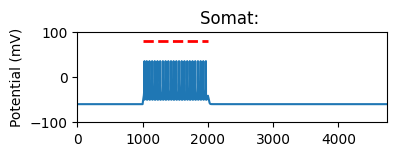

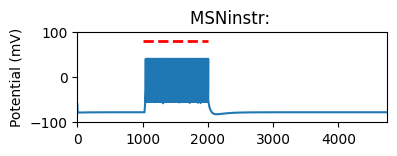

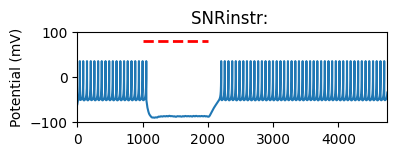

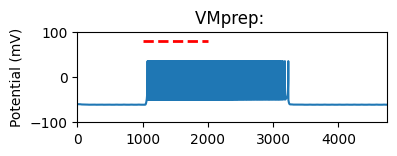

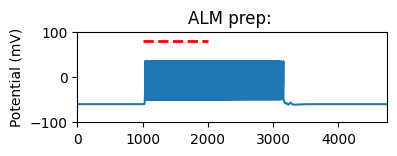

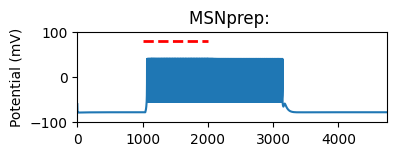

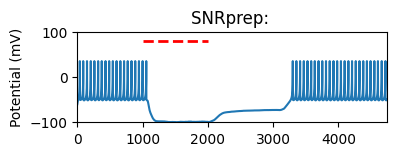

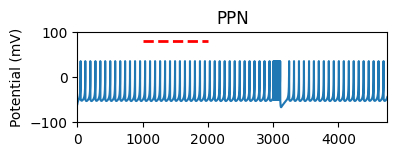

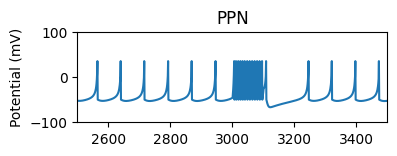

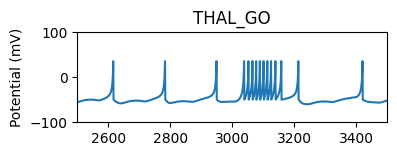

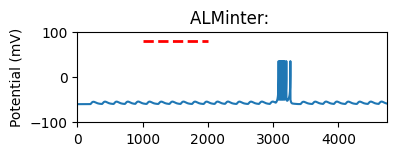

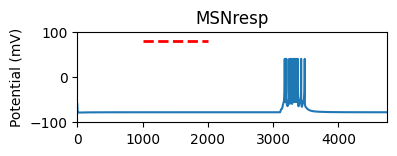

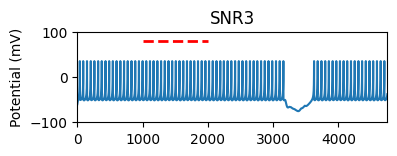

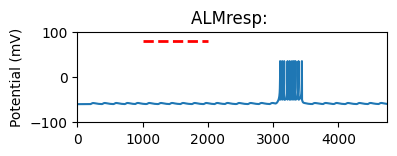

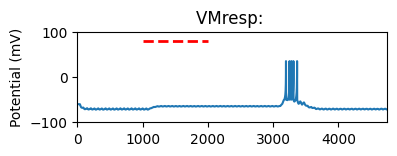


Somat, bins = 1000;
0;24;0;0;0;;

SNRinstr, bins = 1000;
17;2;15;17;18;;

ALMprep, bins = 1000;
0;262;83;8;0;;

VMprep, bins = 1000;
0;176;85;11;0;;

SNRprep, bins = 1000;
17;2;0;13;17;;

SNR3, bins = 1000;
17;18;18;10;18;;

ALM_resp, bins = 1000;
0;0;0;10;0;;

VMresp, bins = 1000;
0;0;0;5;0;;

ALMresp, bins = 1000;
0;0;0;10;0;;


In [6]:
# DESCRIPTION---------------------
label=''
#print('3.27.24c')
print('Sample:',W_Sample, 'SNR background:', SNRinstr.E, '; PPN background=',PPN.E)

print (f'ALM_prep is an {ALMprep.neuron_type} neuron')

print("Weights:")
print(f"Somat_ALM:{Somat_ALMprep}; Somat_MSNinstr:{Somat_MSNinstr};MSNinstr_SNRinstr {MSNinstr_SNRinstr}; SNRinstr_VMprep:{SNRinstr_VMprep}; VMprep_ALMprep:{VMprep_ALMprep};\
  ALMprep_VMprep:{ALMprep_VMprep};   ALMprep_MSNprep:{ALMprep_MSNprep}; MSNprep_SNRprep: {MSNprep_SNRprep};  SNRprep_VMresp: {SNRprep_VMresp}; PPN_THAL_GO:{PPN_THAL_GO}; THAL_GO_ALM_INTER:{THAL_GO_ALM_INTER}")
print(f"ALM_INTER_ALMprep:{ALM_INTER_ALMprep}; ALMresp_MSNresp:{ALMresp_MSNresp}; SNR3_VMresp:{SNR3_VMresp}")


print()
# ANALYSES------------------
from IPython.display import HTML

#print("SPIKE LATENCY from sample onset  (ms)")
#ALMprep_lat=ALMprep.spike_times[0] - Sample_start  #latency from sample to 1st ALMprep spike w no noise)
#print("ALMprep:", ALMprep_lat)

print ("Spike latency from Go-cue onset")
#ALM_INTER_lat=ALM_INTER.spike_times[0]-Go_start  #with no noise
#ALMResp_lat=ALMresp.spike_times[0]-Go_start  #with no noise
#VMResp_lat=VMresp.spike_times[0]-Go_start  #with no noise

#print ("VMResp:", VMResp_lat)
SNR3_lat=SNR3.spike_times[0]-Go_start  #with no noise
#print ("SNR3:", SNR3_lat)


#print ("SPIKE OFFSET relative to Go cue onset (ms)")
#ALMprep_off=max(ALMprep.spike_times-Go_start)  #with no noise
#print("ALMprep:", ALMprep_off)



#____________PLOT__________________________________



Somat.plot_membrane_potential(plot_neuron="Somat", label=label)
#Somat.plot_alpha(plot_neuron="Somat")

MSNinstr.plot_membrane_potential(plot_neuron="MSNinstr", label=label)
#VMprep.plot_alpha(plot_neuron="VMprep")

SNRinstr.plot_membrane_potential(plot_neuron="SNRinstr", label=label)
#SNRinstr.plot_membrane_potential(plot_neuron="SNRinstr", Somat_MSNinstr=Somat_MSNinstr)
#SNR.plot_alpha(plot_neuron="SNR")

VMprep.plot_membrane_potential(plot_neuron="VMprep", label=label)
#VMprep.plot_alpha(plot_neuron="VMprep")

ALMprep.plot_membrane_potential(plot_neuron="ALM prep", label=label)
#ALM.plot_alpha(plot_neuron="ALM")

#ALMprep.plot_membrane_potential(plot_neuron="ALM prep", plot_start=2600, plot_end=3400)

MSNprep.plot_membrane_potential(plot_neuron="MSNprep", label=label)

SNRprep.plot_membrane_potential(plot_neuron="SNRprep", label=label)

PPN.plot_membrane_potential(plot_neuron="PPN")

PPN.plot_membrane_potential(plot_neuron="PPN",  plot_start=2500, plot_end=3500)
#PPN.plot_alpha(plot_neuron="PPN",  plot_start=3000, plot_end=3500)

THAL_GO.plot_membrane_potential(plot_neuron="THAL_GO",  plot_start=2500, plot_end=3500)
#THAL_GO.plot_alpha(plot_neuron="THAL_GO")

ALM_INTER.plot_membrane_potential(plot_neuron="ALMinter", label=label)
#ALM_INTER.plot_membrane_potential(plot_neuron="ALMinter",  plot_start=2500, plot_end=3500)
#ALM_INTER.plot_alpha(plot_neuron="ALMinter")


MSNresp.plot_membrane_potential(plot_neuron="MSNresp")

SNR3.plot_membrane_potential(plot_neuron="SNR3")

ALMresp.plot_membrane_potential(plot_neuron="ALMresp", label=label)
#ALMresp.plot_membrane_potential(plot_neuron="ALMresp", label=label)
VMresp.plot_membrane_potential(plot_neuron="VMresp", label=label)


#_____________ SPIKES PER BIN___________________________________

Somat.spikes_per_bin (neuron_name="Somat", bin_size=1000)
#MSNinstr.spikes_per_bin (neuron_name="MSNinstr", bin_size=1000)
SNRinstr.spikes_per_bin (neuron_name="SNRinstr", bin_size=1000)
ALMprep.spikes_per_bin (neuron_name="ALMprep", bin_size=1000)
# Original spikes per 500ms= 8 8 6 0 5 8 8 8 8 8]
VMprep.spikes_per_bin (neuron_name="VMprep", bin_size=1000)
#MSNprep.spikes_per_bin (neuron_name="MSNprep", bin_size=500)
SNRprep.spikes_per_bin (neuron_name='SNRprep', bin_size=1000)
#PPN.spikes_per_bin (neuron_name='PPN', bin_size=500)
#THAL_GO.spikes_per_bin (neuron_name='THAL_GO', bin_size=500)
#ALM_INTER.spikes_per_bin (neuron_name='ALM_INTER', bin_size=500)
#MSNresp.spikes_per_bin (neuron_name="MSNresp", bin_size=500)
SNR3.spikes_per_bin (neuron_name='SNR3', bin_size=1000)
ALMresp.spikes_per_bin (neuron_name='ALM_resp', bin_size=1000)
VMresp.spikes_per_bin (neuron_name="VMresp", bin_size=1000)

ALMresp.spikes_per_bin (neuron_name='ALMresp', bin_size=1000)

#ALMresp.spikes_per_bin (neuron_name='ALMresp', bin_size=100)

#ALM_INTER.spikes_per_bin (neuron_name='ALM_INTER', bin_size=100)
